In [1]:
import re
import random
from collections import defaultdict

import pybedtools as bt
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import networkx as nx
from zfnetwork import grn, ssa

# Set random seeds for reproducibility
np.random.seed(379397)
random.seed(379397)

# Figure aesthetics
mpl.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = 'Futura'
mpl.rcParams['savefig.transparent'] = True
mpl.rcParams['axes.grid'] = True
mpl.rcParams['grid.linestyle'] = '--'

# KRAB-zinc finger regulatory network analysis.

In the following notebook, we explore some properties of the KRAB-ZNF regulatory network and attempt to model its behavior. To begin, we make a simple analysis of the frequency of TE insertions in the gene body of KZNFs that target that TE. Following this, we build out our model of the gene regulatory network, starting with the simplest incoherent type 1 feed forward motif, and working towards a larger model built from human iPSC data. To keep the size of this notebook manageable, the implementation of the network data structure itself is described in a separate package, `zfnetwork`.

In [2]:
# Load KZNF and TE dataframes
kznf_bed = bt.BedTool('../data/gffs/kzfp_genes_only.bed').sort()
te_bed = bt.BedTool('../data/repeatmasker-out/Homo_sapiens/GCF_009914755.1_T2T-CHM13v2.0_rm.bed')

colnames = ['chrom', 'kznf_start', 'kznf_stop',
            'kznf_name', 'score', 'kznf_strand',
            'source', 'genetype', '_0', 'description',
            'te_chrom', 'te_start', 'te_stop',
            'te_name', 'sw_score', 'te_strand',
            'perc_div', 'perc_ins', 'perc_del',
            '_1', 'teclass', '_2', 
            '_3', '_4', 'dupid']
dropcols = ['te_chrom', '_0', '_1', '_2', '_3', '_4', 'score', 'genetype']

kznf_te_df = kznf_bed.intersect(b=te_bed, wa=True, wb=True).to_dataframe(names=colnames).drop(dropcols, axis=1)
kznf_te_df['tefam'] = kznf_te_df['teclass'].apply(lambda x: x.split('/')[-1])
kznf_te_df['teclass'] = kznf_te_df['teclass'].apply(lambda x: x.split('/')[0])
kznf_te_df['kznf_name'] = kznf_te_df['description'].apply(lambda x: re.match('ID=gene-(.+?);', x).group(1))

# Load dataframe of KZNFs and their target TEs.
padj_threshold = 0.05 # binomial significance threshold for ChIP-seq-based target calling.
kznf_target_df = []
visited = set()
with open('../data/cis-reg/enrich_kzfp_perSubfam/zfp_file_list.txt') as infile:
    for line in infile:
        znf, filename = line.strip().split('\t')
        if znf in visited:
            continue # Because there are multiple replicates for some ZNFs so we just take the first.
        visited.add(znf)
        target_df = pd.read_csv(f'../data/cis-reg/enrich_kzfp_perSubfam/{filename}', sep='\t')
        target_df = target_df.loc[target_df['padj.binomial'] < padj_threshold]
        target_df['kznf_name'] = znf
        target_df = target_df[[target_df.columns[-1]] + list(target_df.columns[:-1])]
        kznf_target_df.append(target_df)
kznf_target_df = pd.concat(kznf_target_df)

# Final filtering to ensure previous dataframes contain same TEs/KZNFs as in kznf_target_df
kznf_set = set(kznf_target_df.kznf_name)
te_set = set(kznf_target_df.subfam_name)
kznf_te_df = kznf_te_df.loc[(kznf_te_df.kznf_name.isin(kznf_set)) & (kznf_te_df.te_name.isin(te_set))]

In [3]:
def get_matching_pairs(kznf_te_pairs: dict, as_set=False) -> dict:
    """Extract pairs of KZNFs and TEs for which the KZNF targets that TE.
    
    Given a dictionary of KZNFs and a list of associated TEs, return a filtered dictionary
    mapping KZNFs to a subset of targeted TE insertions. Whether a TE is targeted or not is
    determined from ChIP-seq data (Tribolet Hardy 2023).

    Arguments:
        kznf_te_pairs: Dictionary of KZNFs mapped to associated TEs, e.g. overlapping gene body.
        as_set: Boolean indicating whether to include all insertions or only unique families.
            if False - include all TE insertions per KZNF
            if True - include only unique TE families, i.e. 10 Alu instances will be recorded as 1.

    Returns:
        Dictionary of KZNFs and matching TE targets.
    """
    
    matches = {}
    for znf, telist in kznf_te_pairs.items():
        target_df = kznf_target_df.loc[kznf_target_df.kznf_name == znf]
        matches[znf] = []
        if len(target_df) is None:
            continue # Because some KZNFs will have no TE targets at a given significance threshold
        
        for te in telist:
            if te in list(target_df.subfam_name):
                    matches[znf].append(te)
                
        if as_set:
            matches[znf] = list(set(matches[znf]))
    return matches

def shuffle_kznf_te_pairs(kznf_te_pairs: dict) -> dict:
    """Shuffles KZNF-TE pairs.
    
    Given a dictionary of KZNFs and a list of associated TEs, shuffle the labels of TEs across the
    dict, while maintaining the number of TEs per KZNF.

    Arguments:
        kznf_te_pairs: Dictionary of KZNFs mapped to associated TEs.

    Returns:
        Dictionary of KZNFs and shuffled TEs.
    """
    
    shuffled_pairs = {}
    te_pool = [te for telist in kznf_te_pairs.values() for te in telist]
    random.shuffle(te_pool)

    i = 0
    for znf, telist in kznf_te_pairs.items():
        l = len(telist)
        shuffled_pairs[znf] = list(set(te_pool[i: i+l]))
        i += l

    return shuffled_pairs

def kznf_permutation_test(kznf_te_pairs, nperms=50, as_set=False) -> (int, list):
    """Permute TEs to generate expected distribution of TEs targeted by each KZNFs.

    Arguments:
        kznf_te_pairs: Dictionary of KZNFs mapped to associated TEs.

    Returns:
        observed_mean_nhits: The mean number of TEs associated with KZNFs.
        expected_mean_nhits: Expected distribution of mean number of TEs associated with KZNFs.
    """
    matching_pairs = get_matching_pairs(kznf_te_pairs, as_set=as_set)
    observed_mean_nhits = np.mean([len(tes) for tes in matching_pairs.values()])
    
    print(f'observed mean number of matching TEs per KZNF: {observed_mean_nhits:.4f}')
    
    expected_mean_nhits = []
    for i in range(1, nperms+1):
        shuffled_kznf_te_pairs = shuffle_kznf_te_pairs(kznf_te_pairs)
        matching_shuffled_pairs = get_matching_pairs(shuffled_kznf_te_pairs, as_set=as_set)
        mean = np.mean([len(tes) for tes in matching_shuffled_pairs.values()])
        expected_mean_nhits.append(mean)
        
        print(f'{i}/{nperms}: {mean:.4f}', end='\r')
    
    return observed_mean_nhits, expected_mean_nhits

In [4]:
### Here we generate the KZNF-TE pairs for use in permutation tests

# Extract simple overlapping KZNF-TE pairs.
kznf_te_pairs = defaultdict(set)
for i, row in kznf_te_df.iterrows():
    kznf_te_pairs[row.kznf_name].add((row.te_name, row.dupid))
for kznf, teset in kznf_te_pairs.items():
    kznf_te_pairs[kznf] = [i[0] for i in list(teset)]
nkznfs = len(kznf_te_pairs.keys())
ntes = len(set(te for telist in kznf_te_pairs.values() for te in telist))
print(f'Overlapping set\n# KZNFs: {nkznfs}\n# TEs: {ntes}')

# Load TRIM28 binding sites in 10kb windows surrounding KZNF genes. See ../scripts/grn/extract_te_cres.sh for details
trim28_kznf_te_pairs = defaultdict(list)
with open('../data/cis-reg/kzfp_TRIM28_regions.txt') as infile:
    for line in infile:
        line = line.strip().split('\t')
        if len(line) == 2:
            znf, te = line
        elif len(line) == 1:
            continue # Because no TRIM28/TE ChIP-seq sites associatedd with this ZNF
        else:
            raise ValueError('Incorrect number of fields in line', line)
        trim28_kznf_te_pairs[znf].append(te)

nkznfs = len(trim28_kznf_te_pairs.keys())
ntes = len(set(te for telist in trim28_kznf_te_pairs.values() for te in telist))
print(f'\nTRIM28-associated set\n# KZNFs: {nkznfs}\n# TEs: {ntes}')


Overlapping set
# KZNFs: 249
# TEs: 474

TRIM28-associated set
# KZNFs: 205
# TEs: 154


In [5]:
# Finally, we're ready for some tests! This could take a while.
npermutations = 1000
permutation_results = {}

for dataset, pairs in [('overlap', kznf_te_pairs),
                       ('TRIM28', trim28_kznf_te_pairs)]:
    print(f'Permuting {dataset} dataset')
    observed_mean_nhits, expected_mean_nhits = kznf_permutation_test(pairs, npermutations, as_set=False)
    permutation_results[dataset] = (observed_mean_nhits, expected_mean_nhits)
    print('\n')

print(f'Permuting overlap_unique_tefam dataset')
permutation_results['overlap_unique_tefam'] = kznf_permutation_test(kznf_te_pairs, npermutations, as_set=True)

Permuting overlap dataset
observed mean number of matching TEs per KZNF: 2.0000
1000/1000: 0.5783

Permuting TRIM28 dataset
observed mean number of matching TEs per KZNF: 0.1073
1000/1000: 0.0780

Permuting overlap_unique_tefam dataset
observed mean number of matching TEs per KZNF: 0.7309


Analysis of targeted TEs with insertions in cognate KZNFs
                 Permutations: 1000
       Total observed matches: 498
  Mean # cognate TEs per KZNF: 2.000
                Expected mean: 0.653
                 Expected std: 0.037
               stds from mean: 35.965
                      p-value: 0.000


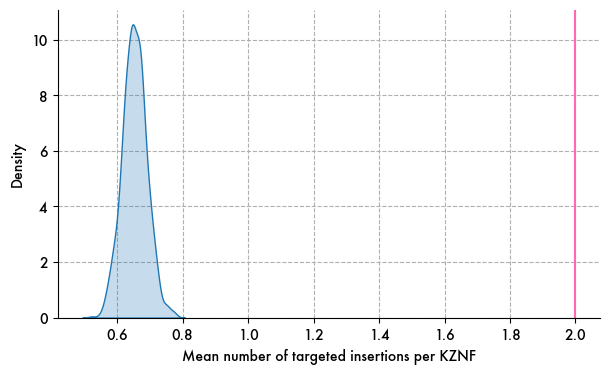

In [11]:
print('Analysis of targeted TEs with insertions in cognate KZNFs')

nmatches = sum(len(v) for v in get_matching_pairs(kznf_te_pairs).values())
observed_mean_nhits, expected_mean_nhits = permutation_results['overlap']
mean, std = np.mean(expected_mean_nhits), np.std(expected_mean_nhits)
norm_rv = stats.norm(loc=mean, scale=std)
pval = 1 - norm_rv.cdf(observed_mean_nhits)

print(f'{"Permutations:":>30} {npermutations}')
print(f'{"Total observed matches:":>30} {nmatches}')
print(f'{"Mean # cognate TEs per KZNF:":>30} {observed_mean_nhits:.3f}')
print(f'{"Expected mean:":>30} {mean:.3f}')
print(f'{"Expected std:":>30} {std:.3f}')
print(f'{"stds from mean:":>30} {(observed_mean_nhits-mean)/std:.3f}')
print(f'{"p-value:":>30} {pval:.3f}')

fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(expected_mean_nhits, fill=True)
ax.axvline(observed_mean_nhits, color='hotpink')

ax.set_xlabel('Mean number of targeted insertions per KZNF')
ax.set_axisbelow(True)
sns.despine()
plt.savefig('../figures/observed_kznf_te_pairs.svg', bbox_inches='tight')

  Mean # cognate TEs per KZNF: 0.731
                Expected mean: 0.654
                 Expected std: 0.036
                      p-value: 0.015
               stds from mean: 2.159


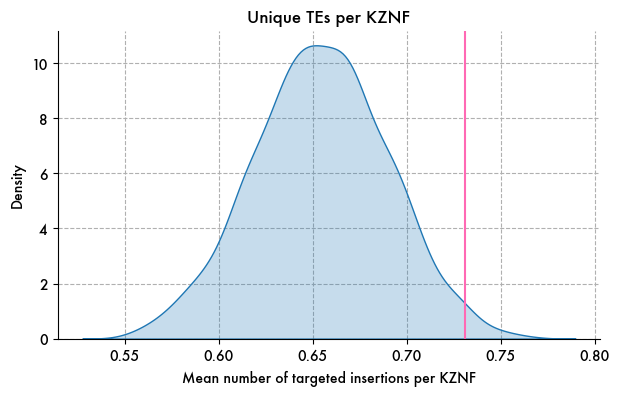

In [7]:
observed_mean_nhits, expected_mean_nhits = permutation_results['overlap_unique_tefam']
mean, std = np.mean(expected_mean_nhits), np.std(expected_mean_nhits)
norm_rv = stats.norm(loc=mean, scale=std)
pval = 1 - norm_rv.cdf(observed_mean_nhits)

print(f'{"Mean # cognate TEs per KZNF:":>30} {observed_mean_nhits:.3f}')
print(f'{"Expected mean:":>30} {mean:.3f}')
print(f'{"Expected std:":>30} {std:.3f}')
print(f'{"p-value:":>30} {pval:.3f}')
print(f'{"stds from mean:":>30} {(observed_mean_nhits-mean)/std:.3f}')

fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(expected_mean_nhits, fill=True)
ax.axvline(observed_mean_nhits, color='hotpink')

plt.title('Unique TEs per KZNF')
ax.set_xlabel('Mean number of targeted insertions per KZNF')
ax.set_axisbelow(True)
sns.despine()
plt.savefig('../figures/unique_observed_kznf_te_pairs.svg', bbox_inches='tight')

  Mean # cognate TEs per KZNF: 0.107
                Expected mean: 0.071
                 Expected std: 0.017
                      p-value: 0.015
               stds from mean: 2.164


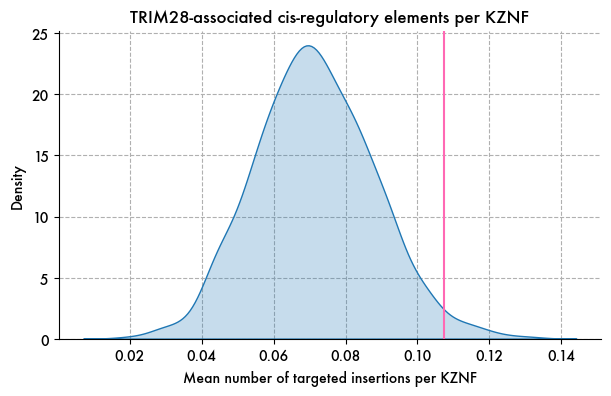

In [10]:
observed_mean_nhits, expected_mean_nhits = permutation_results['TRIM28']
mean, std = np.mean(expected_mean_nhits), np.std(expected_mean_nhits)
norm_rv = stats.norm(loc=mean, scale=std)
pval = 1 - norm_rv.cdf(observed_mean_nhits)
print(f'{"Mean # cognate TEs per KZNF:":>30} {observed_mean_nhits:.3f}')
print(f'{"Expected mean:":>30} {mean:.3f}')
print(f'{"Expected std:":>30} {std:.3f}')
print(f'{"p-value:":>30} {pval:.3f}')
print(f'{"stds from mean:":>30} {(observed_mean_nhits-mean)/std:.3f}')

fig, ax = plt.subplots(figsize=(7, 4))
sns.kdeplot(expected_mean_nhits, fill=True)
ax.axvline(observed_mean_nhits, color='hotpink')

plt.title('TRIM28-associated cis-regulatory elements per KZNF')
ax.set_xlabel('Mean number of targeted insertions per KZNF')
ax.set_axisbelow(True)
sns.despine()
plt.savefig('../figures/TRIM28_observed_kznf_te_pairs.svg', bbox_inches='tight')